# **SGAN:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

In [3]:
df = pd.read_csv('/content/drive/My Drive/dataset/final_train.csv', encoding='ISO-8859-1')
df.head(10)

,Patient_comment,Patient_Category,Doctor_Type,Sentiment
0,rememb feel,Emotional pain,Psychiatrist,0.00
1,carri heavi thing feel like break back,Hair falling out,Dermatologist,0.00
2,much pain move arm,Heart hurts,Cardiologist,0.20
3,son lip pierc swollen skin insid lip grey look...,Infected wound,Surgeon,-0.05
4,muscl lower back ach,Infected wound,Surgeon,0.00
5,muscl pain back muscl pain back leg,Foot ache,Rheumatologist,0.00
6,muscl pain left leg,Shoulder pain,Rheumatologist/Gastro-enterologist,0.00
7,cut finger play footbal appli pain relief crea...,Injury from sports,Rheumatologist,0.00
8,acn face problem derma like itch,Skin issue,Dermatologist,0.00
9,strang rash arm,Foot ache,Rheumatologist,0.00


In [9]:
!pip install transformers
!pip install torch torchvision torchaudio

In [4]:
label_encoder = LabelEncoder()
df['Doctor_Type'] = label_encoder.fit_transform(df['Doctor_Type'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['Patient_comment'], df['Doctor_Type'], test_size=0.1, random_state=42)


In [6]:
# Load the BioBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

# Tokenize the input text
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

In [7]:
class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = MedicalDataset(train_encodings, y_train.to_numpy())
test_dataset = MedicalDataset(test_encodings, y_test.to_numpy())

In [8]:
model = BertForSequenceClassification.from_pretrained('dmis-lab/biobert-v1.1', num_labels=len(label_encoder.classes_))


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import Trainer, TrainingArguments

# Define the logging directory
logging_dir = '/content/drive/My Drive/dataset/log_file(1)'

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=16,    # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir=logging_dir,          # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",      # evaluate at the end of each epoch
    save_strategy="epoch",            # save the model at the end of each epoch
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate ROC AUC only for multi-class problems
    try:
        roc_auc = roc_auc_score(labels, pred.predictions, multi_class='ovr')
    except ValueError:
        roc_auc = None

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
    }

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Add the metrics function here
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.000600,0.067244,0.991004,0.991234,0.991004,0.990972,None
2,0.000300,0.021306,0.995502,0.995656,0.995502,0.995524,None
3,0.000200,0.012865,0.998501,0.998526,0.998501,0.998494,None


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=2250, training_loss=0.03202306054972319, metrics={'train_runtime': 218.4475, 'train_samples_per_second': 82.317, 'train_steps_per_second': 10.3, 'total_flos': 194076617056056.0, 'train_loss': 0.03202306054972319, 'epoch': 3.0})

In [15]:
import logging

# Configure logging
logging.basicConfig(
    filename=f'{logging_dir}/training_log.txt',
    filemode='w',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

# Add logs to capture training information
trainer.log_history = []

# During training
for epoch in range(training_args.num_train_epochs):
    trainer.train()  # Training for one epoch
    metrics = trainer.evaluate()  # Evaluate after each epoch
    logging.info(f"Epoch {epoch+1}: {metrics}")  # Log metrics


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.111900,0.050018,0.994003,0.994124,0.994003,0.993996,None
2,0.000400,0.027531,0.995502,0.995612,0.995502,0.995507,None
3,0.000200,0.014929,0.998501,0.998531,0.998501,0.998495,None


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.000500,0.050201,0.994003,0.994201,0.994003,0.994018,None
2,0.000200,0.017298,0.998501,0.998531,0.998501,0.998495,None
3,0.000200,0.016414,0.998501,0.998531,0.998501,0.998495,None


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.000200,0.040870,0.995502,0.995748,0.995502,0.995534,None
2,0.000300,0.052092,0.995502,0.995762,0.995502,0.995536,None
3,0.000200,0.009407,0.998501,0.998531,0.998501,0.998495,None


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/roc_auc" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


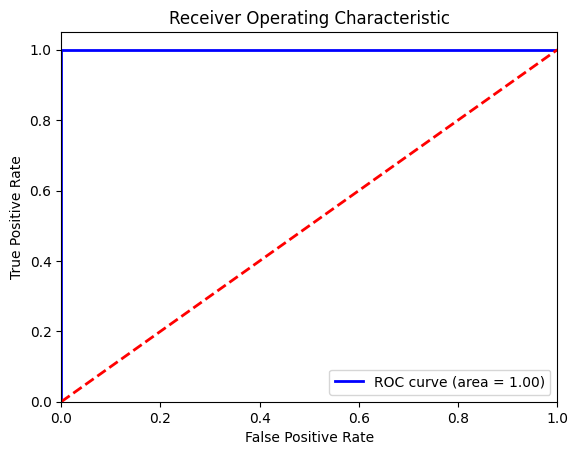

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions from the test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
probabilities = predictions.predictions  # Get probabilities for ROC AUC

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1], pos_label=1)  # Use the correct label for your case
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{logging_dir}/roc_curve.png')  # Save ROC curve to log directory
plt.show()
